# Analysis of new vs returning customer metric definition
Pavel Novotný, 2022

The goal is to define who to consider to be returning customer vs new customer, by looking at the distribution of days between two orders (by customers and orders). Outliers need to be cleared, but the distribution is heavily-tailed. 2 methods are used for outlier detection: isolation forest and 1.5*IQR, z-score was tried to be used but can't be really applied as the distribution isn't normal.

### Import packages & load datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### Load input data

In [2]:
sales_order = pd.read_csv('in/tables/sales-order.csv', dtype=object)

In [3]:
customer_entity = pd.read_csv('in/tables/customer-entity.csv', dtype=object)

check shape 

In [4]:
sales_order.shape

(5187657, 18)

In [5]:
customer_entity.shape

(692955, 12)

### keep only customer groups 0 and 1

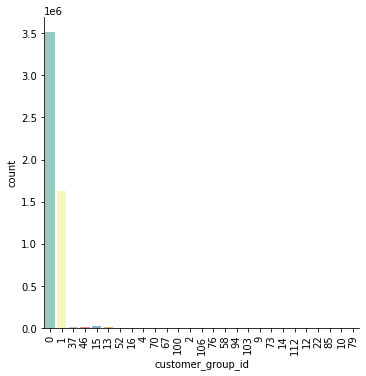

In [6]:
qualitative_colors = sns.color_palette("Set3", 10)
sns.catplot(x="customer_group_id", kind="count", data=sales_order,palette=qualitative_colors)
plt.xticks(rotation=90)
plt.show()

In [7]:
sales_order = sales_order[sales_order['customer_group_id'].isin(['0','1'])]

compare size

In [8]:
sales_order.shape

(5141944, 18)

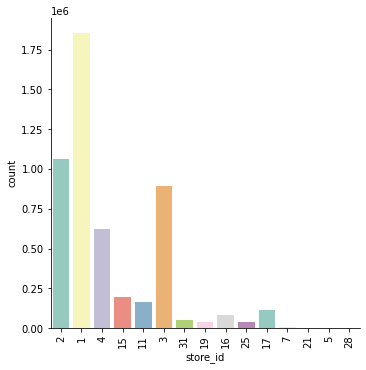

In [9]:
qualitative_colors = sns.color_palette("Set3", 10)
sns.catplot(x="store_id", kind="count", data=sales_order, palette=qualitative_colors)
plt.xticks(rotation=90)
plt.show()

### Keep only stores 1 2 3 4 (SK CZ HU RO)
#### left out for now, as the results were merely different

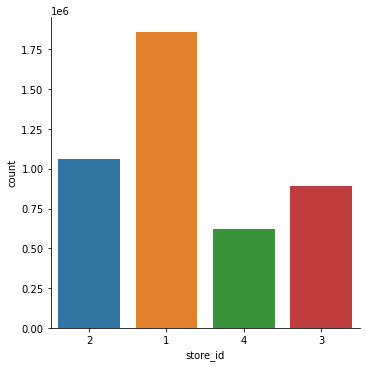

In [10]:
sales_order = sales_order[sales_order['store_id'].isin(['1','2','3','4'])]
sns.catplot(x="store_id", kind="count", data=sales_order)

In [11]:
sales_order['year'] = pd.DatetimeIndex(sales_order['created_at']).year

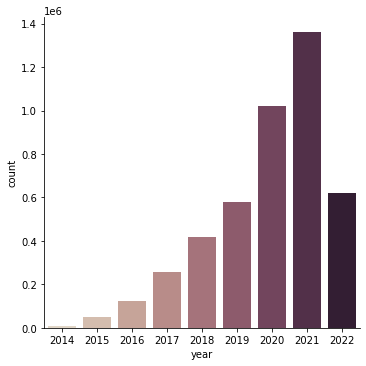

In [12]:
sns.catplot(x="year", kind="count", palette="ch:.25", data=sales_order)
plt.show()

#### Multiple orders by non-registered users under unique customer_id?

In [13]:
customer_entity['email'].value_counts().sort_values(ascending=False)

giveaway@gymbeam.com                 11
odootesting226.1@gmail.com            7
stanislav998@i.ua                     6
test@test.com                         4
vzorky.mkt@gymbeam.com                3
                                     ..
marketahorvatova1651990@seznam.cz     1
adrianhorvath310@gmail.com            1
dodo1446@azet.sk                      1
2409714484@qq.com                     1
mari93@vp.pl                          1
Name: email, Length: 692313, dtype: int64

In [13]:
# see detail of the multiple occurences
#customer_entity.groupby("email").filter(lambda x: len(x) > 1)

### Keep only datapoints with # of orders > 2 

In [16]:
two_plus_orders = sales_order.groupby("customer_email").filter(lambda x: len(x) > 1)

#### Orders by their status in the dataset

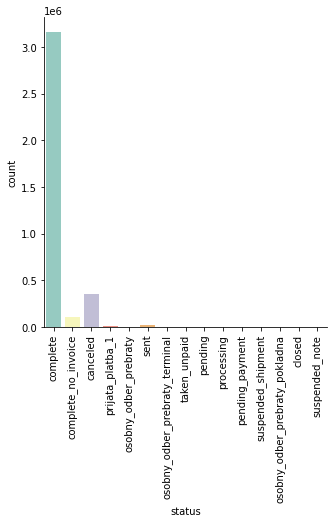

In [18]:
sns.catplot(x="status", kind="count", data=two_plus_orders,palette=qualitative_colors)
plt.xticks(rotation=90)
plt.show()

### Calculate days between 2 subsequential orders - using just calendar date difference, not completed 24hrs
e.g.  23.02.2022 15:10:00 - 22.02.2022 22:22:22 = 0 days -> assumption 'I place another order tomorrow' -> 1 day is better

### Option A: Group by customer_id (only registered customers)

In [ ]:
two_plus_orders['created_at'] = pd.to_datetime(two_plus_orders['created_at'])
two_plus_orders['created_at'] = two_plus_orders['created_at'].dt.date #if commented out, the date difference would be in full days (24hrs) 
# e.g.  23.02.2022 15:10:00 - 22.02.2022 22:22:22 = 0 days -> assumption 'I place another order tomorrow' -> 1 day is better

two_plus_orders = two_plus_orders.sort_values(by=['created_at'])
two_plus_orders['days_between'] = two_plus_orders.groupby('customer_id')['created_at'].apply(lambda x: x.diff()).dt.days

### Option B: Group by customer_email (including non-registered customers)

In [19]:
two_plus_orders['created_at'] = pd.to_datetime(two_plus_orders['created_at'])
two_plus_orders['created_at'] = two_plus_orders['created_at'].dt.date #if commented out, the date difference would be in full days (24hrs) 
# e.g.  23.02.2022 15:10:00 - 22.02.2022 22:22:22 = 0 days -> assumption 'I place another order tomorrow' -> 1 day is better

two_plus_orders = two_plus_orders.sort_values(by=['created_at'])
two_plus_orders['days_between'] = two_plus_orders.groupby('customer_email')['created_at'].apply(lambda x: x.diff()).dt.days


#### First order thus logically has no days_between 
uncomment to see the detail

In [35]:
#two_plus_orders[['customer_id','created_at','days_between']].sort_values(['customer_id','created_at'])

# EDA: Plotting

#### Including non-registered customers

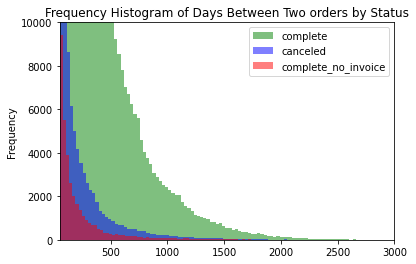

In [20]:
x1 = two_plus_orders.loc[two_plus_orders.status=='complete', 'days_between']
x2 = two_plus_orders.loc[two_plus_orders.status=='canceled', 'days_between']
x3 = two_plus_orders.loc[two_plus_orders.status=='complete_no_invoice', 'days_between']

kwargs = dict(alpha=0.5, bins=100)

plt.hist(x1, **kwargs, color='g', label='complete')
plt.hist(x2, **kwargs, color='b', label='canceled')
plt.hist(x3, **kwargs, color='r', label='complete_no_invoice')
plt.gca().set(title='Frequency Histogram of Days Between Two orders by Status', ylabel='Frequency')
plt.xlim(50,3000)
plt.ylim(0,10000)
plt.legend();

#### Only registered customers

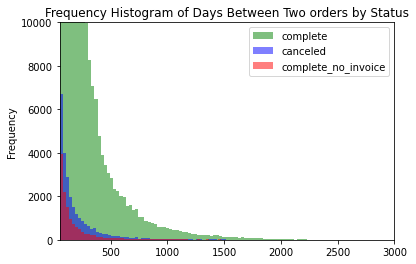

In [20]:
x1 = two_plus_orders.loc[two_plus_orders.status=='complete', 'days_between']
x2 = two_plus_orders.loc[two_plus_orders.status=='canceled', 'days_between']
x3 = two_plus_orders.loc[two_plus_orders.status=='complete_no_invoice', 'days_between']

kwargs = dict(alpha=0.5, bins=100)

plt.hist(x1, **kwargs, color='g', label='complete')
plt.hist(x2, **kwargs, color='b', label='canceled')
plt.hist(x3, **kwargs, color='r', label='complete_no_invoice')
plt.gca().set(title='Frequency Histogram of Days Between Two orders by Status', ylabel='Frequency')
plt.xlim(50,3000)
plt.ylim(0,10000)
plt.legend();

### Max days between 2 orders:

In [17]:
print("complete order max max days between:", two_plus_orders[two_plus_orders['status']=='complete']['days_between'].max())
print("canceled order max days between:", two_plus_orders[two_plus_orders['status']=='canceled']['days_between'].max())


complete order max max days between: 2864.0
canceled order max days between: 2658.0


### Distribution of canceled and complete orders days between

Canceled orders

array([[<AxesSubplot:title={'center':'days_between'}>]], dtype=object)

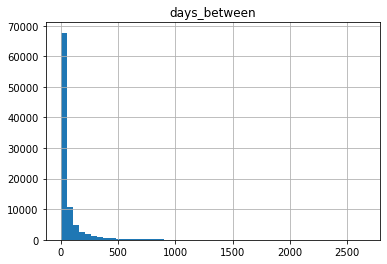

In [27]:
two_plus_orders[two_plus_orders['status']=='canceled'].hist('days_between',bins=50)

Complete orders

array([[<AxesSubplot:title={'center':'days_between'}>]], dtype=object)

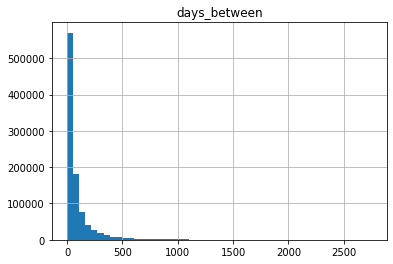

In [28]:
two_plus_orders[two_plus_orders['status']=='complete'].hist('days_between', bins=50)

### Days between 2 orders by order status, doesn't have any significance on the distribution

### Boxplot of days between, looking for outliers

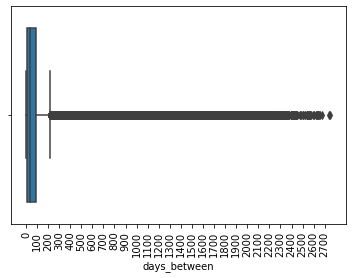

In [34]:
import seaborn as sns
sns.boxplot(data=two_plus_orders,x=two_plus_orders['days_between'])
plt.xticks(np.arange(0, 2800, step=100),rotation=90)
plt.show()

### Distribution plot: How to treat the long tail of the distribution?

#### Including non-registered customers

/home/default/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='days_between', ylabel='Density'>

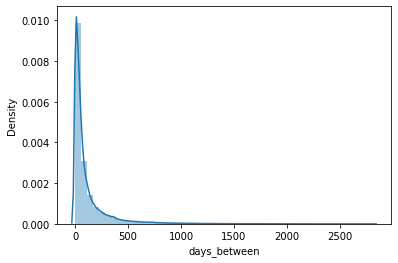

In [21]:
sns.distplot(two_plus_orders['days_between'],kde=True)

####  Only registered customers

/home/default/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='days_between', ylabel='Density'>

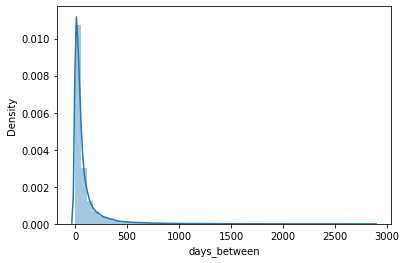

In [36]:
sns.distplot(two_plus_orders['days_between'],kde=True)

## Try removing days between = 0, does it affect skewness?

In [22]:
days_between_excl_0 = two_plus_orders.loc[two_plus_orders['days_between']!=0]
days_between_excl_0 = days_between_excl_0['days_between'].dropna()
days_between_excl_0 = days_between_excl_0.astype(int)

In [23]:
days_between_excl_0.describe()

count    2.733949e+06
mean     1.274584e+02
std      2.097014e+02
min      1.000000e+00
25%      2.200000e+01
50%      5.300000e+01
75%      1.350000e+02
max      2.811000e+03
Name: days_between, dtype: float64

In [21]:
days_between_excl_0.shape

(1023685,)

### Make 95th percentile cut off

In [22]:
q_95 = days_between_excl_0[days_between_excl_0 < days_between_excl_0.quantile(.95)]

### Box-Cox transformation

/home/default/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

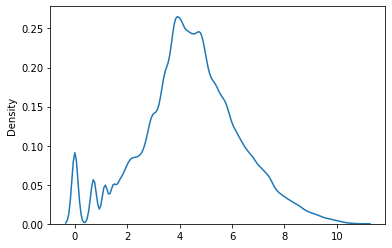

In [23]:
from scipy.stats import boxcox 

#perform Box-Cox transformation on original data
transformed_data, best_lambda = boxcox(days_between_excl_0) 

#plot the distribution of the transformed data values
sns.distplot(transformed_data, hist=False, kde=True) 

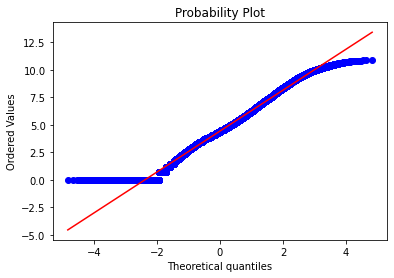

In [24]:
import numpy as np 
import pylab 
import scipy.stats as stats

measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(transformed_data, dist="norm", plot=pylab)
pylab.show()

In [25]:
print(best_lambda)

0.07554441411968432


In [26]:
mean = np.mean(transformed_data) 
# calculate standard deviation
sd = np.std(transformed_data)
# determine a threhold
threshold = 3
# create empty list to store outliers
outliers = []
remaining_transformed_data =[]
# detect outlier
for i in transformed_data: 
    z = (i-mean)/sd # calculate z-score
    if z > threshold:  # identify outliers
        outliers.append(i) # add to the empty list
    else: remaining_transformed_data.append(i)


In [27]:
print(len(remaining_transformed_data))
print(len(outliers))

1022601
1084


/home/default/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

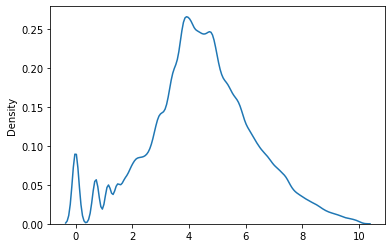

In [28]:
sns.distplot(remaining_transformed_data, hist=False, kde=True) 

In [29]:
import scipy
clean_data = scipy.special.inv_boxcox(remaining_transformed_data, best_lambda)

/home/default/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

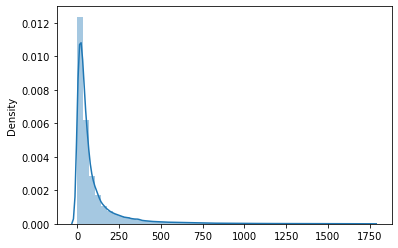

In [30]:
sns.distplot(clean_data, hist=True, kde=True) 

In [31]:
np.quantile(clean_data,q=0.82)

145.99999999999972

In [32]:
clean_data.max()

1757.0000000000011

In [35]:
(clean_data < 143).mean()

0.8153786276367812

### Try Box Cox on 95th percentile cut

/home/default/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

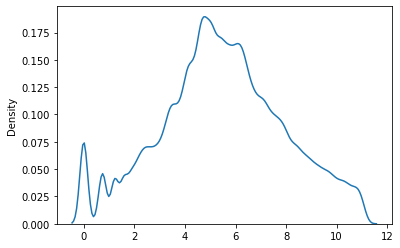

In [52]:
q_95_boxcox, q95_best_lambda = boxcox(q_95) 

#plot the distribution of the transformed data values
sns.distplot(q_95_boxcox, hist=False, kde=True) 

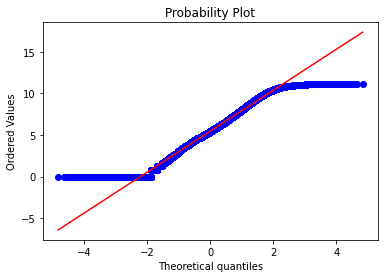

In [53]:

q_95_measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(q_95_boxcox, dist="norm", plot=pylab)
pylab.show()

In [54]:
print(q95_best_lambda)

0.18931141022741377


In [55]:
q95_mean = np.mean(q_95_boxcox) 
# calculate standard deviation
q95_sd = np.std(q_95_boxcox)
# determine a threhold
threshold = 3
# create empty list to store outliers
q95_outliers = []
q95_remaining_boxcox =[]
# detect outlier
for i in q_95_boxcox: 
    z = (i-q95_mean)/q95_sd # calculate z-score
    if z > threshold:  # identify outliers
        q95_outliers.append(i) # add to the empty list
    else: q95_remaining_boxcox.append(i)


/home/default/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

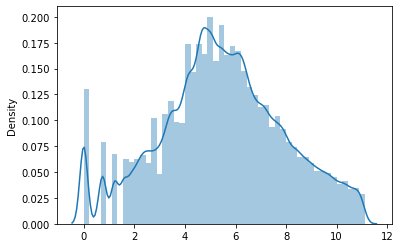

In [56]:
sns.distplot(q95_remaining_boxcox, hist=True, kde=True) 

In [57]:
q95_clean_data = scipy.special.inv_boxcox(q95_remaining_boxcox, q95_best_lambda)

/home/default/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

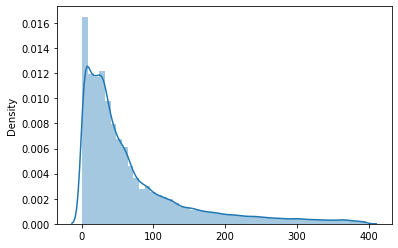

In [58]:
sns.distplot(q95_clean_data, hist=True, kde=True) 

In [59]:
pd.DataFrame(q95_clean_data).describe()

,0
count,1.042746e+06
mean,7.003017e+01
std,7.800018e+01
min,1.000000e+00
25%,1.900000e+01
50%,4.200000e+01
75%,9.000000e+01
max,3.960000e+02


In [60]:
q_95 = days_between_excl_0[days_between_excl_0 < days_between_excl_0.quantile(.95)]

### Log transformation

In [61]:
data_log = np.log(days_between_excl_0)

In [62]:
data_log.skew()

-0.36130821032135235

/home/default/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='days_between', ylabel='Density'>

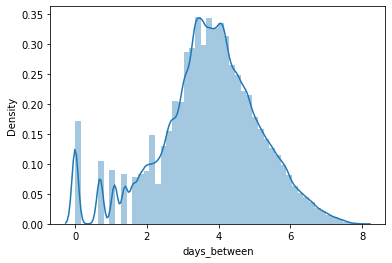

In [63]:
sns.distplot(data_log, hist=True, kde=True) 

In [64]:
data_log.describe()

count    1.097690e+06
mean     3.744963e+00
std      1.418727e+00
min      0.000000e+00
25%      2.995732e+00
50%      3.806662e+00
75%      4.653960e+00
max      7.959975e+00
Name: days_between, dtype: float64

In [65]:
df_data_log = pd.DataFrame(data_log)
df_data_log['zscore'] = stats.zscore(df_data_log)

In [66]:
df_data_log['zscore'].max()

2.9709828048010922

In [169]:
log_removed_IQR = IQR_outlier_deletion(data_log)

Percentiles: 25th=2.996, 75th=4.654, IQR=1.658
Identified outliers: 34643
Non-outlier observations: 1063047


In [118]:
original_IQR = np.exp(log_removed_IQR)

/home/default/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


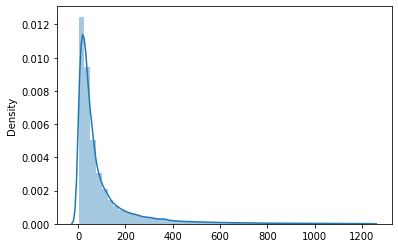

In [121]:
sns.distplot(original_IQR, kde=True,hist=True)
plt.show()

/home/default/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/default/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


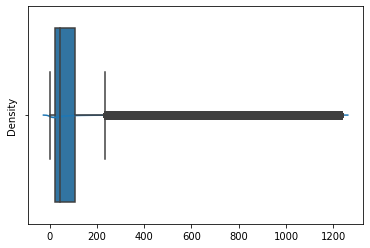

In [120]:
sns.boxplot(original_IQR)

plt.show()

Text(0.5, 1.0, 'After Outliers Removal Log-Transformed Data')

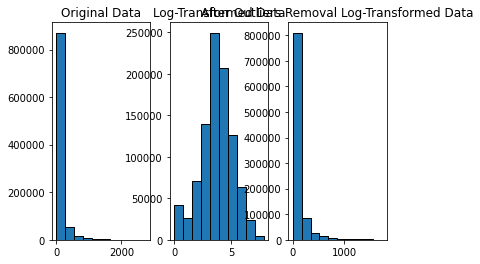

In [97]:
#define grid of plots
fig, axs = plt.subplots(nrows=1, ncols=3)

#create histograms
axs[0].hist(days_between_excl_0, edgecolor='black')
axs[1].hist(data_log, edgecolor='black')
axs[2].hist(clean_data, edgecolor='black')

#add title to each histogram
axs[0].set_title('Original Data')
axs[1].set_title('Log-Transformed Data')
axs[2].set_title('After Outliers Removal Log-Transformed Data')

In [99]:
days_between_excl_0.max()

2750

In [82]:
cut_test = np.exp(df_data_log_cut)

/home/default/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

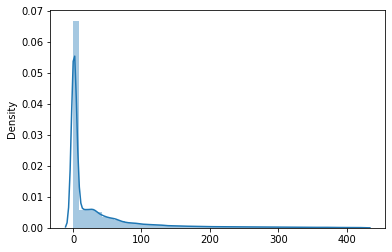

In [83]:
sns.distplot(cut_test, hist=True, kde=True) 

In [42]:
mean = np.mean(data_log) 
# calculate standard deviation
sd = np.std(data_log)
# determine a threhold
threshold = 2
# create empty list to store outliers
outliers = []
remaining_transformed_data_log = []
# detect outlier
for i in data_log: 
    z = (i-mean)/sd # calculate z-score
    if z > threshold:  # identify outliers
        outliers.append(i) # add to the empty list
    else: remaining_transformed_data_log.append(i)


In [47]:
stats.zscore(data_log)

array([-0.63521154, -2.63115588, -1.26029958, ...,  0.22934817,
       -0.25896069, -0.77199072])

In [43]:
len(remaining_transformed_data_log)

1009099

In [44]:
len(outliers)

17841

# Outlier detection and removal

## Option 1: Isolation Forest for outlier detection

In [24]:
from sklearn.ensemble import IsolationForest
np.random.seed(42)
dataset = days_between_excl_0
isolation_forest = IsolationForest(n_estimators=100,random_state=42)
isolation_forest.fit(dataset.values.reshape(-1, 1))
xx = np.linspace(dataset.min(), dataset.max(), len(two_plus_orders)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

#### Including non-registered customers

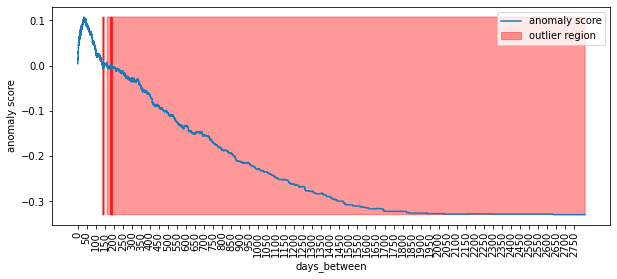

In [25]:
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('days_between')
plt.xticks(np.arange(0, 2800, step=50),rotation=90)
plt.show();

#### Only registered customers

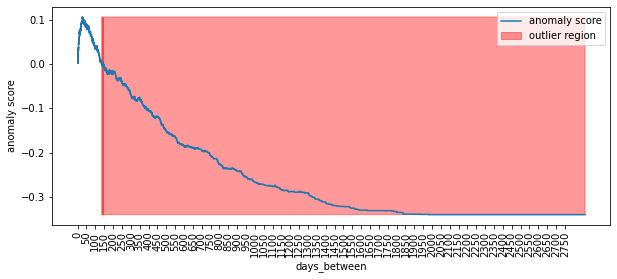

In [41]:
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('days_between')
plt.xticks(np.arange(0, 2800, step=50),rotation=90)
plt.show();

## Outlier cut off using Isolation Forest

### Results: max ordinary value for days between = `+-135-150` (multiple inits of the method (only registered customers)

In [26]:
outlier_index = outlier==-1
values = xx[outlier_index]

In [27]:
values.min()

139.49976286102012

## Option 2: IQR for outlier detection

###  Results: max ordinary value for days between = `229`  (only registered customers)

#### Define the function for IQR outlier deletion

In [28]:
from numpy import percentile

def IQR_outlier_deletion(data):
    # calculate interquartile range
    q25, q75 = percentile(data, 25), percentile(data, 75)
    iqr = q75 - q25
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    # identify outliers
    outliers = [x for x in data if x <= lower or x >= upper]
    print('Identified outliers: %d' % len(outliers))
    # remove outliers
    outliers_removed = [x for x in data if x > lower and x < upper]
    print('Non-outlier observations: %d' % len(outliers_removed))
    return outliers_removed

#### Function call

In [29]:
outliers_removed_IQR = IQR_outlier_deletion(days_between_excl_0)

Percentiles: 25th=22.000, 75th=135.000, IQR=113.000
Identified outliers: 297388
Non-outlier observations: 2436561



### Distribution & boxplot , max days = `229`

/home/default/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


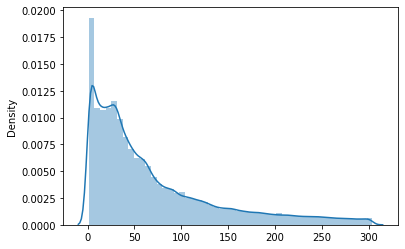

In [30]:
sns.distplot(outliers_removed_IQR, kde=True,hist=True)
plt.show()

/home/default/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


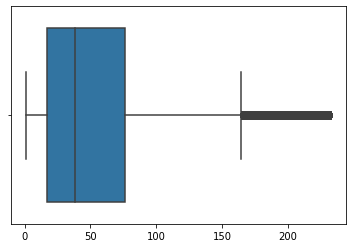

In [71]:
sns.boxplot(outliers_removed_IQR)
plt.show()

In [45]:
pd.DataFrame(outliers_removed_IQR).describe()

,0
count,911830.000000
mean,55.089395
std,51.540830
min,1.000000
25%,18.000000
50%,38.000000
75%,76.000000
max,232.000000


In [73]:
print(percentile(outliers_removed_IQR, 90))

133.0


# Distribution of avg days between orders by CUSTOMERS

### 4 methods: 
* 1. isolation forest based clean data -> avg days for each customer, looking at mean and median
* 2. isolation forest based clean data -> median days for each customer, looking at mean and median
* 3. 1.5*IQR based clean data -> avg days for each customer, looking at mean and median
* 4. 1.5*IQR based clean data -> median days for each customer, looking at mean and median

### Results: +- the same for each method, isolation forest based approach gives lower number of days in general

In [57]:
df_wo_outliers = two_plus_orders[(~two_plus_orders['days_between'].isna()) & 
                                (two_plus_orders['status'].isin(['complete']))]

In [59]:
#df_wo_outliers = two_plus_orders[(~two_plus_orders['days_between'].isna())]

df_wo_outliers_IF = df_wo_outliers[df_wo_outliers['days_between']<=136]
df_wo_outliers_IQR = df_wo_outliers[df_wo_outliers['days_between']<=232]

In [126]:
customer_days_IF_mean = df_wo_outliers_IF.groupby(by=['customer_id','store_id']).mean()
customer_days_IF_median = df_wo_outliers_IF.groupby(by=['customer_id','store_id']).median()
customer_days_IQR_mean = df_wo_outliers_IQR.groupby(by=['customer_id','store_id']).mean()
customer_days_IQR_median = df_wo_outliers_IQR.groupby(by=['customer_id','store_id']).median()

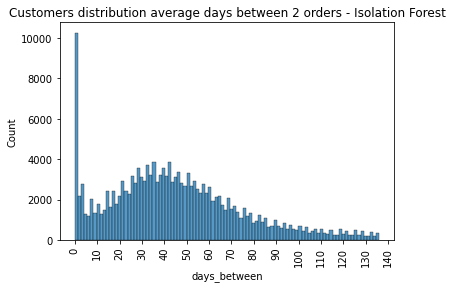

In [61]:
sns.histplot(customer_days_IF_mean['days_between']).set(title='Customers distribution average days between 2 orders - Isolation Forest')
plt.xticks(np.arange(0, 141, step=10),rotation=90)
plt.show()

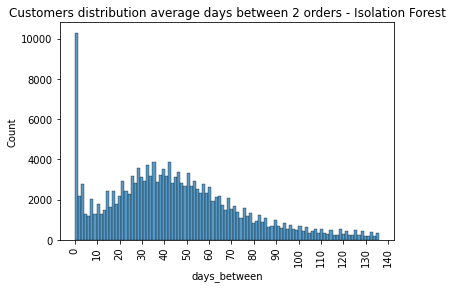

In [100]:
sns.histplot(data=customer_days_IF_mean,x='days_between').set(title='Customers distribution average days between 2 orders - Isolation Forest')
plt.xticks(np.arange(0, 141, step=10),rotation=90)
plt.show()

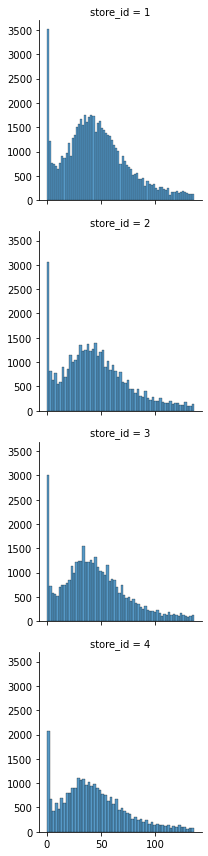

In [98]:
g = sns.FacetGrid(customer_days_IF_mean, row="store_id")
g.map_dataframe(sns.histplot, x="days_between")

In [107]:
customer_days_IF_mean = customer_days_IF_mean.reset_index()

### Isolation Forest - customer days mean - overall

90. percentil:

In [119]:
print(percentile(customer_days_IF_mean['days_between_avg'], 90))

86.33333333333333


In [111]:
customer_days_IF_mean.rename(columns={'days_between':'days_between_avg'},inplace=True)
customer_days_IF_mean[['days_between_avg']].describe()

,days_between_avg
count,166216.000000
mean,45.029881
std,29.996963
min,0.000000
25%,23.750000
50%,41.700000
75%,62.000000
max,136.000000


### Isolation Forest - customer days mean - SK

In [115]:
customer_days_IF_mean[customer_days_IF_mean['store_id']=='1'][['days_between_avg']].describe()

,days_between_avg
count,59305.000000
mean,46.086853
std,29.721200
min,0.000000
25%,25.333333
50%,43.000000
75%,63.000000
max,136.000000


### Isolation Forest - customer days mean - CZ

In [112]:
customer_days_IF_mean[customer_days_IF_mean['store_id']=='2'][['days_between_avg']].describe()

,days_between_avg
count,39691.000000
mean,45.103406
std,30.514114
min,0.000000
25%,23.000000
50%,41.826087
75%,62.961538
max,136.000000


### Isolation Forest - customer days mean - HU

In [113]:
customer_days_IF_mean[customer_days_IF_mean['store_id']=='3'][['days_between_avg']].describe()

,days_between_avg
count,39647.000000
mean,44.478464
std,29.939992
min,0.000000
25%,23.333333
50%,41.000000
75%,61.333333
max,136.000000


### Isolation Forest - customer days mean - RO

In [116]:
customer_days_IF_mean[customer_days_IF_mean['store_id']=='4'][['days_between_avg']].describe()

,days_between_avg
count,27573.000000
mean,43.443547
std,29.830101
min,0.000000
25%,22.000000
50%,39.416667
75%,60.307692
max,136.000000


### Isolation Forest - customer days median - overall

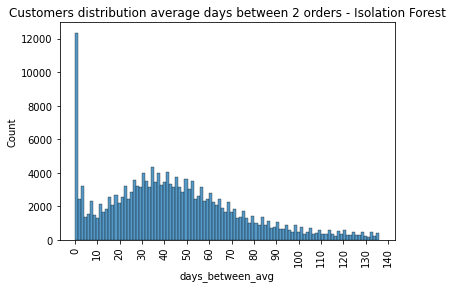

In [229]:
sns.histplot(customer_days_IF_mean['days_between_avg']).set(title='Customers distribution average days between 2 orders - Isolation Forest')
plt.xticks(np.arange(0, 141, step=10),rotation=90)
plt.show()

In [224]:
customer_days_IF_median.rename(columns={'days_between':'days_between_median'},inplace=True)
customer_days_IF_median[['days_between_median']].describe()

,days_between_median
count,185213.000000
mean,42.857467
std,31.451857
min,0.000000
25%,19.000000
50%,37.000000
75%,61.500000
max,136.000000


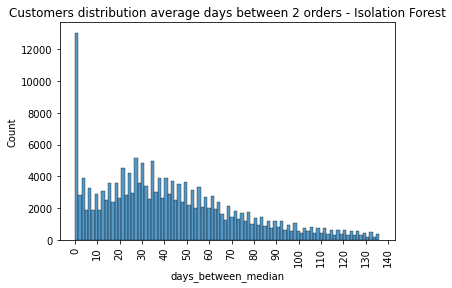

In [228]:
sns.histplot(customer_days_IF_median['days_between_median']).set(title='Customers distribution average days between 2 orders - Isolation Forest')
plt.xticks(np.arange(0, 141, step=10),rotation=90)
plt.show()

### IQR - customer days mean - overall

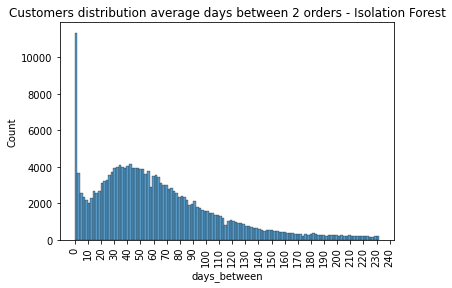

In [215]:
sns.histplot(customer_days_IQR_mean['days_between']).set(title='Customers distribution average days between 2 orders - Isolation Forest')
plt.xticks(np.arange(0, 241, step=10),rotation=90)
plt.show()

In [123]:
print(percentile(customer_days_IQR_mean['days_between'], 90))

126.5


/home/default/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='days_between'>

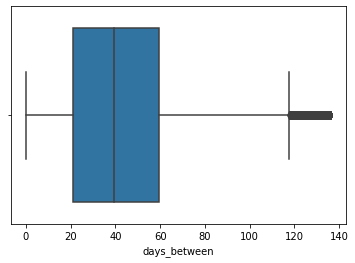

In [192]:
sns.boxplot(customer_days_mean['days_between'])

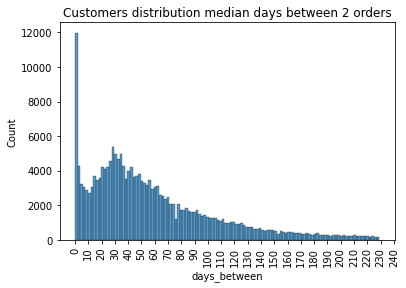

In [165]:
sns.histplot(customer_days_median['days_between']).set(title='Customers distribution median days between 2 orders')
plt.xticks(np.arange(0, 250, step=10),rotation=90)
plt.show()

In [127]:
print(percentile(customer_days_IQR_median['days_between'], 90))

128.0


In [168]:
customer_days_median[['days_between']].describe()

,days_between
count,197774.000000
mean,58.056509
std,48.404344
min,0.000000
25%,23.000000
50%,45.500000
75%,81.000000
max,229.000000


<AxesSubplot:xlabel='days_between', ylabel='Count'>

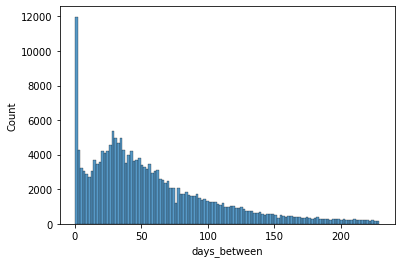

In [129]:
sns.histplot(customer_days_median['days_between'])

In [130]:
customer_days_mean['days_between'].describe()

count    197774.000000
mean         61.873643
std          46.844055
min           0.000000
25%          28.333333
50%          53.000000
75%          85.000000
max         229.000000
Name: days_between, dtype: float64

In [131]:
customer_days_median['days_between'].describe()

count    197774.000000
mean         58.056509
std          48.404344
min           0.000000
25%          23.000000
50%          45.500000
75%          81.000000
max         229.000000
Name: days_between, dtype: float64

In [95]:
df_wo_outliers.status.drop_duplicates()

3916333                          canceled
1038341                          complete
3504402               complete_no_invoice
4597235             osobny_odber_prebraty
2985548                  prijata_platba_1
2619898    osobny_odber_prebraty_terminal
2881977    osobny_odber_prebraty_pokladna
2417540                            closed
1292348                      taken_unpaid
441338                               sent
4696222                   pending_payment
1745552                           pending
2240421                    suspended_note
499506                         processing
Name: status, dtype: object

In [ ]:
import scipy as sp
a=pd.Series(days_between_excl_0)
p=sp.stats.mstats.normaltest(a, axis=0).pvalue
if p<0:
   print ('distribution is not normal')
p=sp.stats.mstats.normaltest(np.log(a), axis=0).pvalue
if p<0.05:
   print ('distribution is not log-normal',p)

In [98]:
import scipy as sp
shape, location, scale = sp.stats.lognorm.fit(days_between_excl_0)
mu, sigma = np.log(scale), shape

In [99]:
print(mu, sigma)

3.7951351133346183 1.3296522802077182


# Other code and methods, used only for EDA, mainly trying to normalize the distribution and detect outliers using z-score

## Kolmogorov Smirnov - checking the normality - the distribution isn't lognormal

In [106]:
sp.stats.kstest(days_between_excl_0, "loguniform", sp.stats.lognorm.fit(days_between_excl_0))

KstestResult(statistic=nan, pvalue=nan)

In [104]:
sp.stats.kstest(days_between_incl_0, "lognorm", sp.stats.lognorm.fit(days_between_incl_0))

KstestResult(statistic=0.08311417273448801, pvalue=0.0)

In [111]:
days_between_excl_0.describe()

count    1.020321e+06
mean     1.014133e+02
std      1.754643e+02
min      1.000000e+00
25%      2.000000e+01
50%      4.400000e+01
75%      1.040000e+02
max      2.750000e+03
Name: days_between, dtype: float64

In [38]:
from numpy import percentile

data = days_between_incl_0

# calculate interquartile range
q25_incl_0, q75_incl_0 = percentile(data, 25), percentile(data, 75)
iqr = q75_incl_0 - q25_incl_0
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers_incl_0 = [x for x in data if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed_incl_0 = [x for x in data if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Percentiles: 25th=20.000, 75th=104.000, IQR=81.000
Identified outliers: 110100
Non-outlier observations: 910221


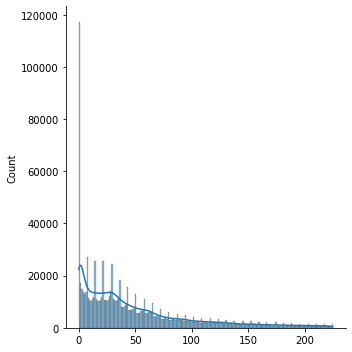

In [39]:
sns.displot(outliers_removed_incl_0, kde=True)

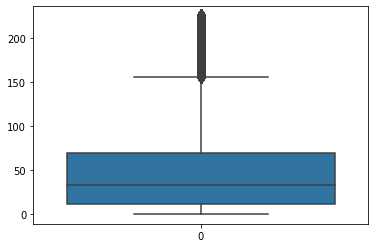

In [45]:
sns.boxplot(data=outliers_removed_incl_0,fliersize=10)
plt.show()

In [41]:
max(outliers_removed_incl_0)

225

In [42]:
two_plus_orders['grand_total_float'] = two_plus_orders['grand_total'].astype(float)
df = two_plus_orders[['status','days_between','grand_total_float']]
#df = df[df['days_between']<=80]
df = df[df['status'].isin(['complete','canceled'])]

[(0.0, 200.0)]

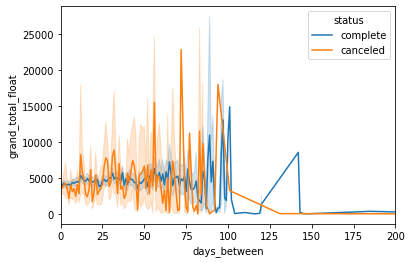

In [43]:
# plot line graph on axis #1
g = sns.lineplot(
    y='grand_total_float',
    x='days_between',
    data=df, 
    sort=True, 
    hue='status')
g.set(xlim=(0, 200))

In [ ]:
# plot line graph on axis #1
ax1 = sns.barplot(
    y='grand_total_float',
    x='days_between',
    data=df, 
    #sort=True, 
    hue='status')

ax1.set_ylabel('avg_grand_total')
#ax1.set_ylim(0, 5000)
ax1.legend(['avg_grand_total'], loc="upper left")
# set up the 2nd axis
ax2 = ax1.twinx()
# plot bar graph on axis #2
sns.displot(outliers_removed, 
    color='orange', 
)
ax2.grid(b=False) # turn off grid #2
ax2.set_ylabel('days_between')
#ax2.set_ylim(0, 10000)
ax2.legend(['days_between'], loc="upper right")


 
    

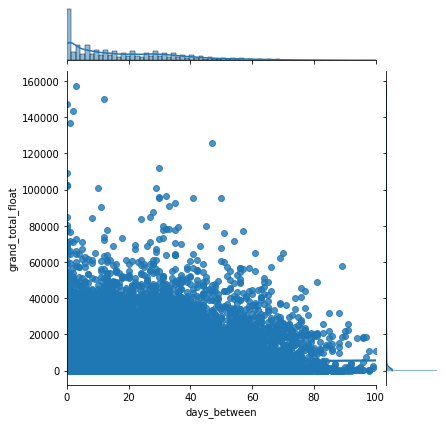

In [44]:
sns.jointplot(x = 'days_between', y = 'grand_total_float', data = df[df['days_between']<=100], kind = 'reg')


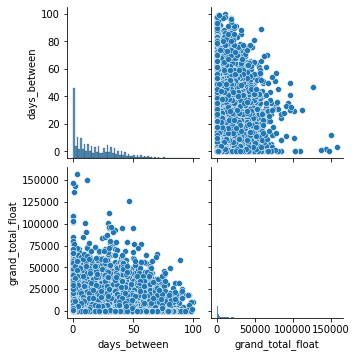

In [45]:
sns.pairplot(df[df['days_between']<=100])

In [46]:
two_plus_orders.sort_values('grand_total_float')

# identify outliers with interquartile range

from numpy import percentile

data = two_plus_orders.loc[two_plus_orders['days_between']<=80,'grand_total_float']

# calculate interquartile range
q25, q75 = percentile(data, 25), percentile(data, 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers = [x for x in data if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in data if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Percentiles: 25th=71.500, 75th=2980.000, IQR=2908.500
Identified outliers: 10061
Non-outlier observations: 44565


/home/default/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

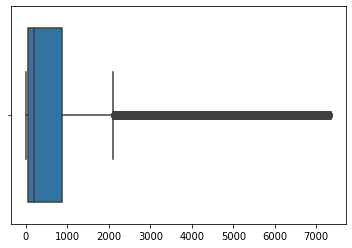

In [47]:
sns.boxplot(outliers_removed)

In [13]:
customer_entity

,entity_id,email,group_id,increment_id,store_id,created_at,created_in,updated_at,is_active,firstname,lastname,gender
0,85722,adam.bodnar@freemail.hu,1,NaN,3,2017-12-26 17:46:17,GymBeamHu,2017-12-26 18:39:28,1,Ádám,Bodnár,NaN
1,1678018,2145932101@qq.com,1,NaN,16,2022-03-29 21:47:01,RU,2022-03-29 21:47:01,1,【澳门金沙】携手七大顶级游戏平台，鼎力打造娱乐盛宴！注册送38元：www.973338.co...,隗周柯,0
2,532546,at_georgiev1@abv.bg,1,NaN,15,2020-06-09 16:56:52,GymBeamBg,2021-04-19 16:44:49,1,Атанас,Георгиев,0
3,1674127,4008564@qq.com,1,NaN,16,2022-03-29 21:15:56,RU,2022-03-29 21:15:56,1,全球顶尖博弈平台。【澳门金沙】注册送38元圆梦彩金：www.111208.com/? 存8送...,叶焦充,0
4,236227,kolesj@centrum.cz,1,NaN,2,2019-07-29 07:55:37,GymBeamCz,2020-06-01 18:23:12,1,Jozef,Kolesár,1
...,...,...,...,...,...,...,...,...,...,...,...,...
688271,121774,zanazitus007@gmail.com,1,NaN,3,2018-09-26 10:47:47,GymBeamHu,2020-11-19 12:04:46,1,Zana,Zita,NaN
688272,1681216,517516725@qq.com,1,NaN,16,2022-03-29 22:13:26,RU,2022-03-29 22:13:26,1,豪礼满天下，【澳门金沙】：www.973338.com/? 登陆送38元，存8送18元，别再...,曾封池,0
688273,1476058,539924404@qq.com,1,NaN,16,2022-03-28 14:02:56,RU,2022-03-28 14:02:57,1,全球顶尖博弈平台。【澳门金沙】注册送38元圆梦彩金：www.973338.com/? 存8送...,萧岑昌,0
688274,1201507,cervik-michal@seznam.cz,1,NaN,2,2021-11-21 22:52:55,GymBeamCz,2021-11-21 22:52:56,1,Michal,Červík,1


In [14]:
customer_entity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688276 entries, 0 to 688275
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   entity_id     688276 non-null  object
 1   email         688276 non-null  object
 2   group_id      688276 non-null  object
 3   increment_id  0 non-null       object
 4   store_id      688276 non-null  object
 5   created_at    688276 non-null  object
 6   created_in    615685 non-null  object
 7   updated_at    688276 non-null  object
 8   is_active     688276 non-null  object
 9   firstname     688274 non-null  object
 10  lastname      688274 non-null  object
 11  gender        540040 non-null  object
dtypes: object(12)
memory usage: 63.0+ MB


In [ ]:
sales_order[sales_order['customer_id']=='958513']

In [ ]:
two_plus_orders.value_counts('customer_id')

In [ ]:
two_plus_orders.sort_values('created_at')